# **LSVT Voice Rehabilitation Classification**

The goal is to assess whether voice rehabilitation treatment results in *acceptable* or *unacceptable* phonations using machine learning models. This is a binary classification problem with an unbalanced dataset (33% acceptable, 66% unacceptable). Previous research has achieved ~90% accuracy using traditional models like Random Forest and SVM. We aim to improve upon these results using advanced techniques and hyperparameter tuning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

## Functions for Plotting

In [2]:
def barplot(metric_lst, xlabels="", title=""):
    """
    Produces standard barplot with one bar per section.
    """
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(metric_lst)), metric_lst, zorder=3)
    ax.set_xticks(np.arange(len(metric_lst)))
    ax.set_xticklabels(xlabels, rotation=30, ha="right")
    ax.set_title(title)
    ax.legend()
    plt.grid(zorder=0)
    plt.show()

def barplotvs2(metric_lst, ylabel, xlabels="", title=""):
    """
    Produces standard barplot with two bars per section.
    """
    metric1_lst, metric2_lst = metric_lst
    w = 0.35
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(metric1_lst)) - w/2, metric1_lst, w, label="default", zorder=3)
    ax.bar(np.arange(len(metric2_lst)) + w/2, metric2_lst, w, label="tuned", zorder=3)
    ax.set_xticks(np.arange(len(metric1_lst)))
    ax.set_xticklabels(xlabels, rotation=50, ha="right")
    plt.ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.grid(zorder=0)
    plt.show()

def barplotvs3(metric_lst, ylabel, xlabels="", title=""):
    """
    Produces standard barplot with three bars per section.
    """
    metric1_lst, metric2_lst, metric3_lst = metric_lst
    w = 0.25
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(metric1_lst)) - w, metric1_lst, w, label="tuned on accuracy", zorder=3)
    ax.bar(np.arange(len(metric2_lst)), metric2_lst, w, label="tuned on f1-micro", zorder=3)
    ax.bar(np.arange(len(metric3_lst)) + w, metric3_lst, w, label="tuned on f1-macro", zorder=3)
    ax.set_xticks(np.arange(len(metric1_lst)))
    ax.set_xticklabels(xlabels, rotation=50, ha="right")
    plt.ylabel(ylabel)
    ax.set_title(title)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(zorder=0)
    plt.show()

## Functions for Data Inspection

In [3]:
def check_NaN_values(df_features, df_labels):
    """
    Checks if data contains NaN values.
    """
    if df_features.isnull().values.any() or df_labels.isnull().values.any():
        print("Data contains NaN values.")
    else:
        print("Data does not contain NaN values.")


def check_balance(df_features, df_labels):
    """
    Checks size and balance of dataset.
    """
    if df_features.shape[0] != df_labels.shape[0]:
        print("Number of samples is not equal to the number of labels.")
        return

    n_samples = df_features.shape[0]
    n_features = len(df_features.columns)

    print("Number of samples:", n_samples)
    print("Number of features:", n_features)
    print(df_labels["Binary class 1=acceptable, 2=unacceptable"].value_counts() / n_samples)

## Functions for Statistics

In [4]:
def confusion_pre_rec(confusion_mat):
    """
    Calculates and returns precision, recall, f1_score from confusion matrix.
    """
    tn, fp, fn, tp = confusion_mat.ravel()
    p =  None if (tp + fp) == 0 else tp / (tp + fp)
    r =  None if (tp + fn) == 0 else tp / (tp + fn)
    f1 = None if p is None or r is None or p + r == 0 else 2 * p * r / (p + r)
    return p, r, f1


def get_testing_statistics(clf, true_labels, features=None, do_print=True):
    """
    Returns a dictionary with accuracy, f1_micro_average, f1_macro_average,
    precision, recall, f1 score and confusion matrix.
    """
    pred_labels = clf.predict(features)

    conf_matrix = confusion_matrix(true_labels, pred_labels)
    p, r, f1 = confusion_pre_rec(conf_matrix)

    # collecting results in a dictionary
    res = {
        "accuracy": accuracy_score(true_labels, pred_labels),
        "f1_micro_average": f1_score(true_labels, pred_labels, average="micro"),
        "f1_macro_average": f1_score(true_labels, pred_labels, average="macro"),
        "precision": p,
        "recall": r,
        "f1_score": f1,
        "confusion_matrix": conf_matrix
    }

    # displaying results
    if do_print:
        print("accuracy:", res["accuracy"])
        print("f1 micro averaged:", res["f1_micro_average"])
        print("f1 macro averaged:", res["f1_macro_average"])
        print("precision:", res["precision"])
        print("recall:", res["recall"])
        print("f1 score:", res["f1_score"])
        if features is not None and not features.empty:
            ConfusionMatrixDisplay(confusion_matrix=res["confusion_matrix"], display_labels=clf.classes_).plot()

    return res

## Data Inspection

In [5]:
df_features = pd.read_excel (r'LSVT_voice_rehabilitation.xlsx')
df_labels = pd.read_excel (r'LSVT_voice_rehabilitation.xlsx', sheet_name=1)
check_NaN_values(df_features, df_labels)
check_balance(df_features, df_labels)

Data does not contain NaN values.
Number of samples: 126
Number of features: 310
Binary class 1=acceptable, 2=unacceptable
2    0.666667
1    0.333333
Name: count, dtype: float64


In [6]:
df_features.head(3)

,Jitter->F0_abs_dif,Jitter->F0_dif_percent,Jitter->F0_PQ5_classical_Schoentgen,Jitter->F0_PQ5_classical_Baken,Jitter->F0_PQ5_generalised_Schoentgen,Jitter->F0_abs0th_perturb,Jitter->F0_CV,Jitter->F0_TKEO_mean,Jitter->F0_TKEO_std,Jitter->F0_TKEO_prc5,...,det_TKEO_std4_1_coef,det_TKEO_std4_2_coef,det_TKEO_std4_3_coef,det_TKEO_std4_4_coef,det_TKEO_std4_5_coef,det_TKEO_std4_6_coef,det_TKEO_std4_7_coef,det_TKEO_std4_8_coef,det_TKEO_std4_9_coef,det_TKEO_std4_10_coef
0,0.088112,0.041697,0.000480,-3.723304e-06,0.000422,2.458381,6.332164e-07,47.021079,1366.430390,-7.103323,...,2.527583,7.088978,19.753255,54.335046,145.528630,375.097397,921.296579,2137.079844,4697.131077,9931.208257
1,0.161798,0.057364,0.000677,5.466365e-06,0.000206,2.592066,7.228518e-07,93.557936,2582.922776,-23.284761,...,2.841881,7.977363,22.203504,60.993338,163.560972,421.010306,1036.092589,2404.072562,5284.082128,11165.095662
2,0.554508,0.642913,0.007576,-7.443871e-07,0.006488,12.691326,6.946246e-04,52.988422,466.682635,-45.308680,...,1.806103,5.078616,14.135923,38.641654,103.466808,264.654626,649.657090,1507.384591,3315.804236,6974.600636


In [7]:
df_labels.head(3)

,"Binary class 1=acceptable, 2=unacceptable"
0,1
1,2
2,2


The dataset is imbalanced, with roughly 2:1 ratio between the classes (33% acceptable, 66% unacceptable). Given that this imbalance could affect performance, especially recall for the minority class, the use of oversampling is an appropriate solution. Additionally, the dataset has a little more than 300 features, which could introduce noise. The use of PCA and variance thresholding is critical in reducing the dimensionality and focusing on the most relevant features. Finally, many features are related to voice characteristics like jitter, perturbation and coefficients, which are commonly associated with speech analysis and have proven relevance in phonation assessments. It would be beneficial to explore their correlation with the target classes.

## Data Split

In [8]:
train, test, train_labels, test_labels = train_test_split(df_features, df_labels, test_size=0.2)

## Pipeline Definition

The data pipeline involves oversampling to mitigate class imbalance, variance thresholding for feature selection, normalization and PCA for dimensionality reduction. These steps are crucial for ensuring that your models are trained on balanced and well-processed data. More specifically:

* <ins>Oversampling</ins>: It helps with the imbalanced nature of the dataset, ensuring the models are exposed to a balanced set of classes during training.
* <ins>Variance Thresholding</ins>: Applying it after the MinMax scaler ensures features with large magnitudes are reduced to a comparable scale and filtering features based on variance at this stage avoids bias due to differing ranges. The use of StandardScaler to normalize variance improves training speed and accuracy, as many models like especially SVM assume normalized data.

It is good practice to verify if any preprocessing steps can be omitted. If a layer does not improve performance, it can be removed to simplify the pipeline.


In [9]:
oversample = RandomOverSampler(sampling_strategy="minority")
mean_scaler = MinMaxScaler()
std_scaler = StandardScaler().fit(train)
variance_thrh = VarianceThreshold()

def create_pipeline(clf):
    """
    Creates a pipeline that includes oversampling, normalization, variance threshold
    and a model.
    """
    pipeline = Pipeline([
        ("oversampler", oversample),
        ("data_norm_mean", mean_scaler),
        ("variance_threshold", variance_thrh),
        ("data_norm_std", std_scaler),
        ("pca", PCA()),
        ("classifier", clf)
    ])
    return pipeline


## Initialization of Model Space

In [10]:
# initial model selection
models = [
    ("Dummy1", DummyClassifier(strategy="constant", constant=1)),
    ("Dummy2", DummyClassifier(strategy="constant", constant=2)),
    ("DummyMF", DummyClassifier(strategy="most_frequent")),
    ("DummyUni", DummyClassifier(strategy="uniform")),
    ("DummyStr", DummyClassifier(strategy="stratified")),
    ("GaussianNB", GaussianNB()),
    ("KNN", KNeighborsClassifier()),
    ("SVC", SVC()),
    ("LogReg", LogisticRegression()),
    ("RandForest", RandomForestClassifier()),
    ("DecisionTree", DecisionTreeClassifier()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("MLP", MLPClassifier())
]

## Initialization of Hyperparameter Space

In [11]:
pca_candidates = [None]
threshold_candidates = [0.0]

# hyperparameter space
param_grid = [
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates
    },  # Dummy classifier (constant = 1)
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates
    },  # Dummy classifier (constant = 2)
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates
    },  # Dummy classifier (most frequent)
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates
    },  # Dummy classifier (uniform)
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates
    },  # Dummy classifier (stratified)
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates,
        "classifier__var_smoothing": np.logspace(0, -9, num=10)
    },  # GaussianNB
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates,
        "classifier__n_neighbors": [3, 5, 7, 9],
        "classifier__weights": ["uniform", "distance"],
        "classifier__p": [1, 2]
    },  # KNN
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates,
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__kernel": ["linear", "rbf", "poly", "sigmoid"],
        "classifier__gamma": ["scale", "auto", 0.001, 1]
    },  # SVC
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates,
        "classifier__C": [0.1, 1, 10],
        "classifier__solver": ["liblinear", "lbfgs"],
        "classifier__max_iter": [100, 1000]
    },  # Logistic Regression
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates,
        "classifier__n_estimators": [25, 50, 100, 150],
        "classifier__max_features": ["sqrt", "log2", None],
        "classifier__max_depth": [3, 6, 9, 12],
        "classifier__max_leaf_nodes": [3, 6, 9]
    },  # Random Forest
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates,
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [3, 6, 9, 12],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4]
    },  # DecisionTree
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates,
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__max_depth": [3, 5, 7],
        "classifier__subsample": [0.8, 1.0]
    },  # GradientBoostingClassifier
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates,
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.01, 0.1, 0.5, 1.0]
    },  # AdaBoost
    {
        "pca__n_components": pca_candidates,
        "variance_threshold__threshold": threshold_candidates,
        "classifier__hidden_layer_sizes": [(25,), (50,), (100,),
                                           (100, 50), (50, 25), (100, 50, 25),
                                           (150,), (200,), (100, 100)],
        "classifier__solver": ["adam", "sgd", "lbfgs"],
        "classifier__activation": ["relu", "tanh"],
        "classifier__alpha": [0.0001, 0.001, 0.01],
        "classifier__max_iter": [200, 1000]
    }  # MLP
]


## Scoring Criteria

In [12]:
scoring_criteria = ["accuracy", "f1_micro", "f1_macro"]

## Hyperparameter Tuning

In [13]:
best_models = {}
default_scores = {}
tuned_scores = {}
for sc in scoring_criteria:
    default_scores[sc] = []
    tuned_scores[sc] = []


for i, (name, model) in enumerate(models):
    print(f"Processing {name}...")

    model_default = copy.deepcopy(model)
    pipeline_default = create_pipeline(model_default)

    # cross-validation without hyperparameter tuning
    clf_scores = cross_validate(pipeline_default, train, np.ravel(train_labels), cv=10,
                                scoring=scoring_criteria)

    pipeline = create_pipeline(model)
    tmp = {}
    for sc in scoring_criteria:
        default_scores[sc].append(clf_scores["test_" + sc].mean())

        # performing grid search (cross-validation with best found hyperparameters)
        search = GridSearchCV(pipeline, param_grid[i], cv=10, scoring=sc, n_jobs=-1)
        search.fit(train, np.ravel(train_labels))

        tmp[sc] = search.best_estimator_
        tuned_scores[sc].append(search.cv_results_["mean_test_score"][search.best_index_])
    best_models[name] = tmp

print("Done!")

Processing Dummy1...
Processing Dummy2...
Processing DummyMF...
Processing DummyUni...
Processing DummyStr...
Processing GaussianNB...
Processing KNN...
Processing SVC...
Processing LogReg...
Processing RandForest...
Processing DecisionTree...
Processing GradientBoosting...
Processing AdaBoost...
Processing MLP...
Done!


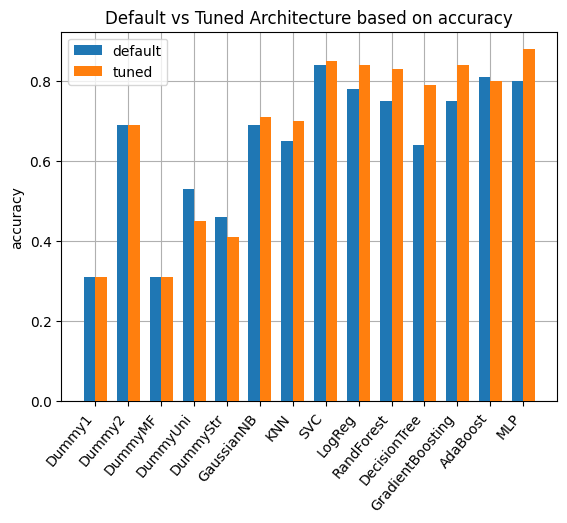

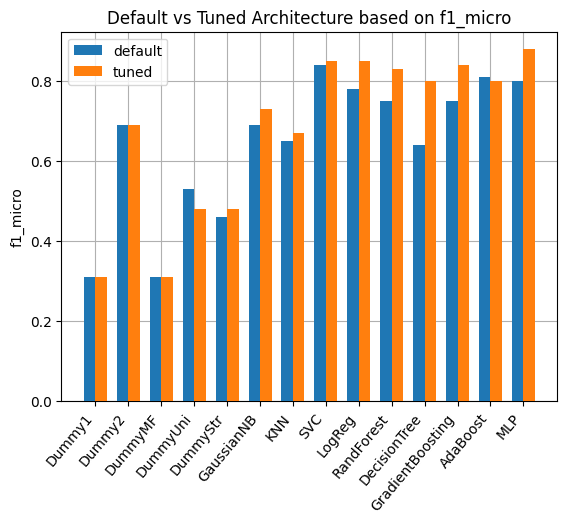

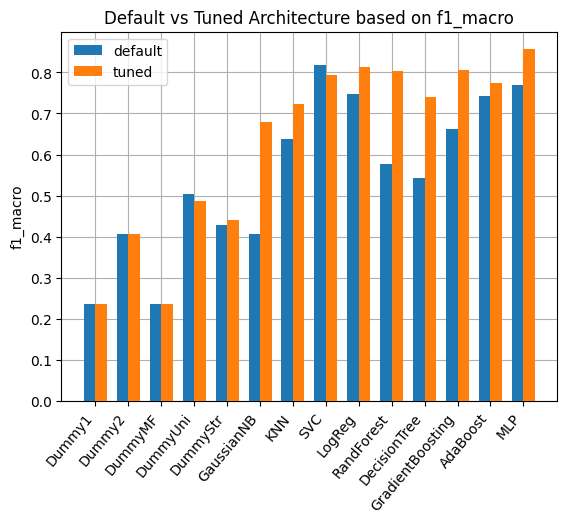

In [14]:
# plotting metrics to compare default and tuned model architectures
for sc in scoring_criteria:
    barplotvs2([default_scores[sc], tuned_scores[sc]],
               sc,
               xlabels=[name for name, _ in models],
               title="Default vs Tuned Architecture based on " + sc)

Tuning hyperparameters results in significant performance boosts across all models. GridSearchCV helped us find the optimal hyperparameters, leading to improved metrics compared to default models. The improvement shows that careful hyperparameter tuning is essential in making models more adaptable to the specific characteristics of our dataset.

## Testing of Best Architectures

In [15]:
selected_models = ["SVC", "LogReg", "MLP"]

---------- Results for models tuned on accuracy ----------
---------- SVC ----------
accuracy: 0.8846153846153846
f1 micro averaged: 0.8846153846153846
f1 macro averaged: 0.8755980861244019
precision: 0.8333333333333334
recall: 1.0
f1 score: 0.9090909090909091
---------- LogReg ----------
accuracy: 0.8846153846153846
f1 micro averaged: 0.8846153846153846
f1 macro averaged: 0.8844444444444445
precision: 1.0
recall: 0.8
f1 score: 0.888888888888889
---------- MLP ----------
accuracy: 0.8846153846153846
f1 micro averaged: 0.8846153846153846
f1 macro averaged: 0.8830584707646176
precision: 0.9285714285714286
recall: 0.8666666666666667
f1 score: 0.896551724137931
---------- Results for models tuned on f1_micro ----------
---------- SVC ----------
accuracy: 0.8461538461538461
f1 micro averaged: 0.8461538461538461
f1 macro averaged: 0.8300653594771241
precision: 0.7894736842105263
recall: 1.0
f1 score: 0.8823529411764706
---------- LogReg ----------
accuracy: 0.9230769230769231
f1 micro averag

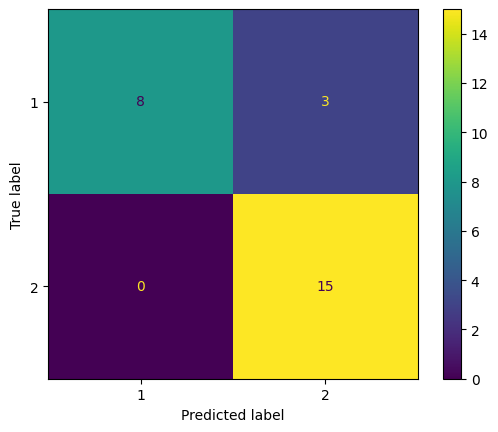

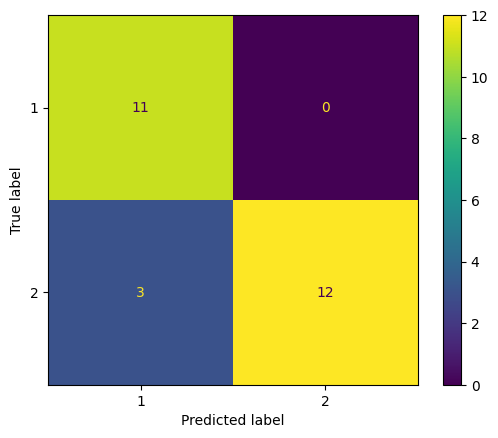

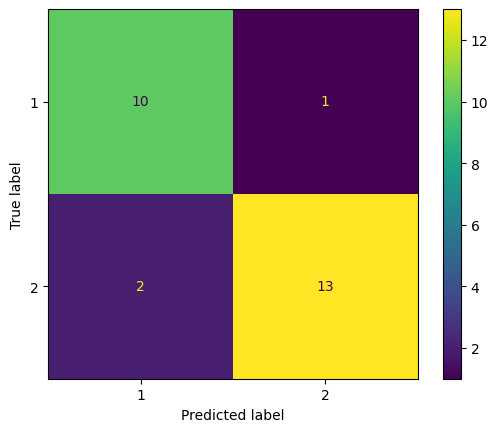

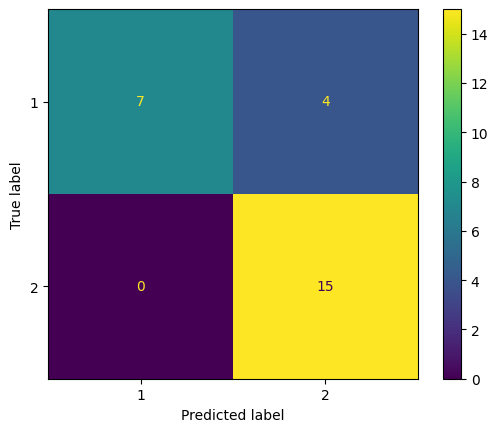

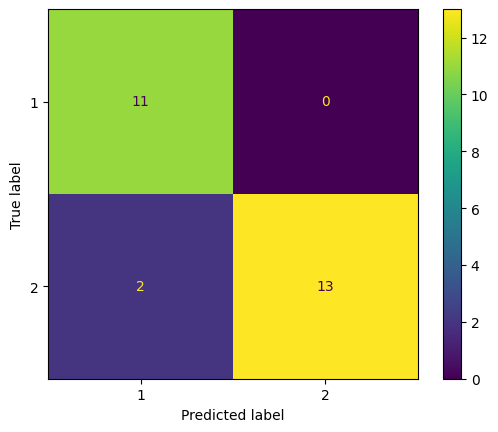

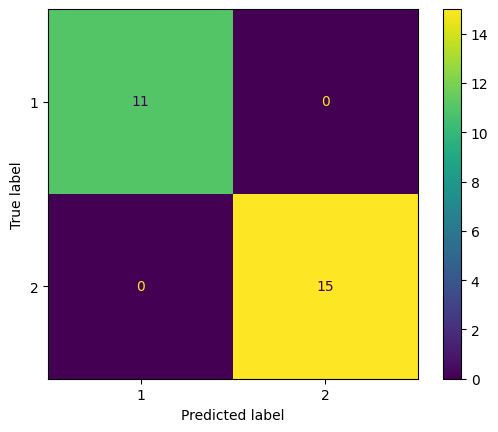

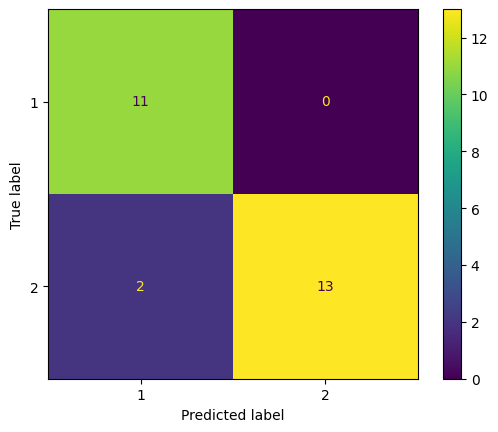

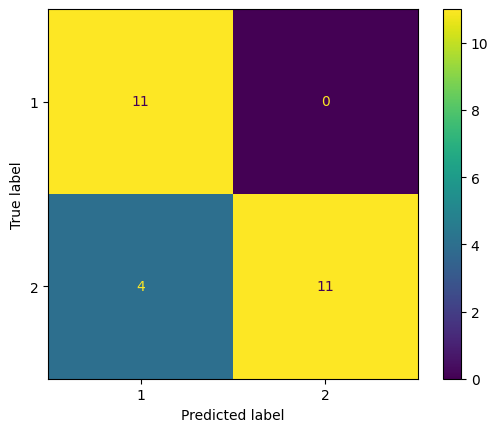

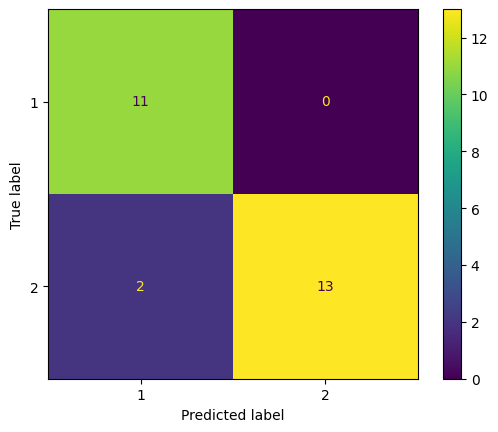

In [16]:
testing_accuracy_lst = []
for sc in scoring_criteria:
    print("---------- Results for models tuned on " + sc + " ----------")
    testing_accuracy_single_score_type_lst = []
    for model_name in selected_models:
        print("---------- " + model_name + " ----------")
        model = best_models[model_name][sc]
        stats = get_testing_statistics(model, test_labels, test)
        testing_accuracy_single_score_type_lst.append(stats["accuracy"])
    testing_accuracy_lst.append(testing_accuracy_single_score_type_lst)

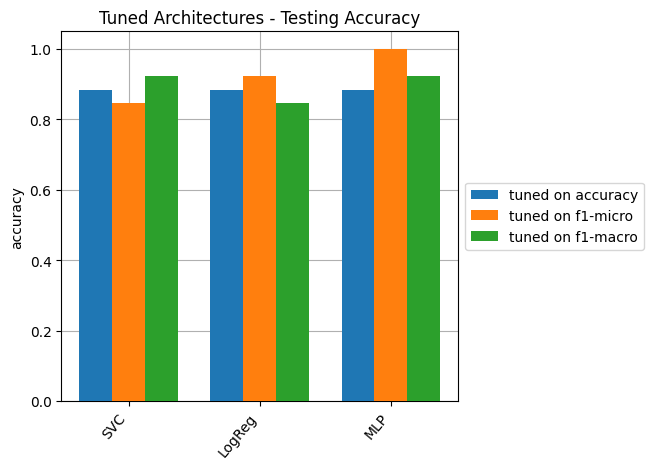

In [22]:
barplotvs3(testing_accuracy_lst,
           "accuracy",
           xlabels=selected_models,
           title="Tuned Architectures - Testing Accuracy")

In [19]:
for model in selected_models:
    print("Architecture for", model)
    print(best_models[model]["f1_micro"])

Architecture for SVC
Pipeline(steps=[('oversampler',
                 RandomOverSampler(sampling_strategy='minority')),
                ('data_norm_mean', MinMaxScaler()),
                ('variance_threshold', VarianceThreshold()),
                ('data_norm_std', StandardScaler()), ('pca', PCA()),
                ('classifier', SVC(C=1, gamma=1, kernel='poly'))])
Architecture for LogReg
Pipeline(steps=[('oversampler',
                 RandomOverSampler(sampling_strategy='minority')),
                ('data_norm_mean', MinMaxScaler()),
                ('variance_threshold', VarianceThreshold()),
                ('data_norm_std', StandardScaler()), ('pca', PCA()),
                ('classifier', LogisticRegression(C=0.1))])
Architecture for MLP
Pipeline(steps=[('oversampler',
                 RandomOverSampler(sampling_strategy='minority')),
                ('data_norm_mean', MinMaxScaler()),
                ('variance_threshold', VarianceThreshold()),
                ('data_norm_std',

## Observations

The table above contains the performance metrics associated with each architecture that was tuned based on the scoring criteria of F1-micro.

| Model              | Tuned Hyperparameters (based on F1-micro)                     | Accuracy | Precision | Recall  | F1 score | F1-micro | F1-macro |
|--------------------|---------------------------------------------------------------|----------|-----------|---------|----------|----------|----------|
| SVC                | C = 1, gamma = 1, kernel = 'poly'                             | 84.62%   | 78.95%    | 100.00% | 88.24%   | 84.62%   | 83.01%   |
| Logistic Regression| C = 0.1                                                       | 92.31%   | 100.00%   | 86.67%  | 92.86%   | 92.31%   | 92.26%   |
| MLPClassifier      | alpha = 0.01, hidden_layer_sizes = (100,50), solver = 'lbfgs' | 100.00%  | 100.00%   | 100.00% | 100.00%  | 100.00%  | 100.00%  |


**SVC:**
- Recall of 100% means the SVC model identifies all "unacceptable" cases (class 2) correctly, which is crucial in the medical context since failing to identify unacceptable cases could have severe consequences for patient treatment. However, Precision is lower (78.95%), indicating that many of the cases it predicts as unacceptable (class 2) are actually acceptable (class 1). This high false positive rate could lead to unnecessary concern or additional testing.
- F1-score (88.24%) balances Precision and Recall and shows that the model leans toward being more conservative, ensuring that no unacceptable case is missed. F1-micro (84.62%) gives an overall performance measure weighted by class frequency and F1-macro (83.01%) considers both classes equally, showing a slight imbalance favoring Recall over Precision.

**Logistic Regression:**
- Precision is perfect (100%), meaning that all predicted unacceptable cases (class 2) are indeed truly unacceptable. There are no false positives in this model's predictions. Recall (86.67%) is slightly lower than the SVC model, meaning it misses some unacceptable cases, but overall it performs quite well.
- The F1-score (92.86%) strikes a good balance between Precision and Recall. The F1-macro (92.26%) shows consistent performance across both classes, indicating that the model performs well regardless of the class distribution. F1-micro (92.31%) aligns with the Accuracy, confirming that the model is robust overall.

**MLPClassifier**
- This model delivers perfect scores across the board, meaning it identifies all unacceptable cases correctly (100% Recall) and also predicts them without error (100% Precision).
- Both F1-micro and F1-macro scores are at 100%, indicating flawless performance for both classes regardless of class distribution. In medical contexts, this is ideal as it ensures that all unacceptable cases are identified without making any false positive or false negative errors.